# Libraries

In [2]:
# Import necessary libraries
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Download the dataset using KaggleHub
path = kagglehub.dataset_download("nelgiriyewithana/global-weather-repository")

# Load the dataset
file_path = path + "/GlobalWeatherRepository.csv"
df = pd.read_csv(file_path)

# Inspect dataset structure
print("Available Columns in the Dataset:")
print(df.columns)

Available Columns in the Dataset:
Index(['country', 'location_name', 'latitude', 'longitude', 'timezone',
       'last_updated_epoch', 'last_updated', 'temperature_celsius',
       'temperature_fahrenheit', 'condition_text', 'wind_mph', 'wind_kph',
       'wind_degree', 'wind_direction', 'pressure_mb', 'pressure_in',
       'precip_mm', 'precip_in', 'humidity', 'cloud', 'feels_like_celsius',
       'feels_like_fahrenheit', 'visibility_km', 'visibility_miles',
       'uv_index', 'gust_mph', 'gust_kph', 'air_quality_Carbon_Monoxide',
       'air_quality_Ozone', 'air_quality_Nitrogen_dioxide',
       'air_quality_Sulphur_dioxide', 'air_quality_PM2.5', 'air_quality_PM10',
       'air_quality_us-epa-index', 'air_quality_gb-defra-index', 'sunrise',
       'sunset', 'moonrise', 'moonset', 'moon_phase', 'moon_illumination'],
      dtype='object')


# Data Cleaning and Preprocessing

In [3]:
# Handle missing values (if any)
print("\nMissing Values Before Handling:")
print(df.isnull().sum())

# Separate numeric and categorical columns
numeric_cols = df.select_dtypes(include=[float, int]).columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Fill missing values
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])

print("\nMissing Values After Handling:")
print(df.isnull().sum())



Missing Values Before Handling:
country                         0
location_name                   0
latitude                        0
longitude                       0
timezone                        0
last_updated_epoch              0
last_updated                    0
temperature_celsius             0
temperature_fahrenheit          0
condition_text                  0
wind_mph                        0
wind_kph                        0
wind_degree                     0
wind_direction                  0
pressure_mb                     0
pressure_in                     0
precip_mm                       0
precip_in                       0
humidity                        0
cloud                           0
feels_like_celsius              0
feels_like_fahrenheit           0
visibility_km                   0
visibility_miles                0
uv_index                        0
gust_mph                        0
gust_kph                        0
air_quality_Carbon_Monoxide     0
air_quality_Ozo

## Handle Outliers Using IQR Method

In [4]:
# Function to cap outliers using IQR
def cap_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    df[column] = np.clip(df[column], lower, upper)

# Apply the function to numeric columns
for col in ['temperature_celsius', 'precip_mm']:
    if col in df.columns:
        cap_outliers(df, col)

# Normalize numeric columns
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

## Exploratory Data Analysis (EDA)

### Temperature Trend Over Time

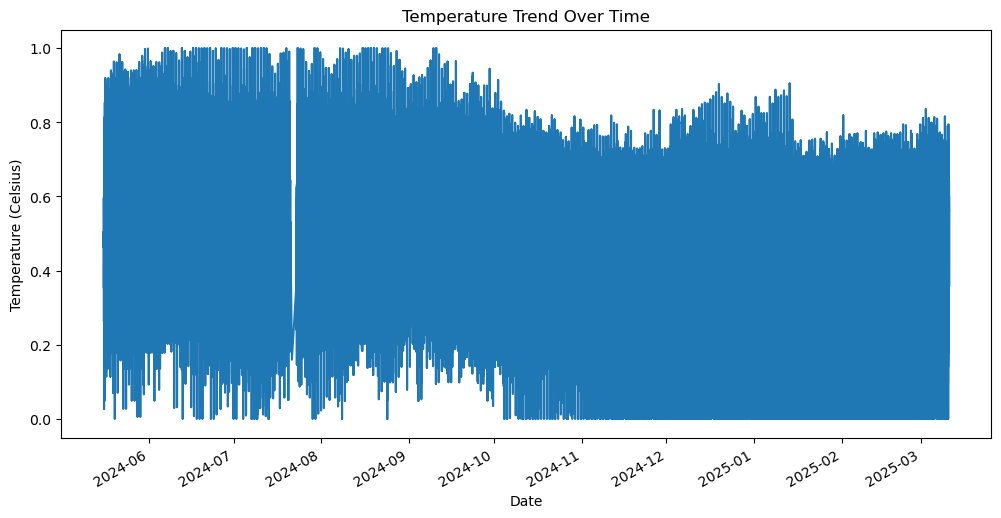

In [5]:
# Convert 'last_updated' column to datetime
timestamp_column = 'last_updated'
if timestamp_column in df.columns:
    df[timestamp_column] = pd.to_datetime(df[timestamp_column])
    df.set_index(timestamp_column, inplace=True)
    
    # Plot Temperature Trend
    plt.figure(figsize=(12, 6))
    df['temperature_celsius'].plot(title="Temperature Trend Over Time")
    plt.xlabel("Date")
    plt.ylabel("Temperature (Celsius)")
    plt.show()
else:
    print(f"Column '{timestamp_column}' not found in the dataset.")


### Precipitation Trend Over Time

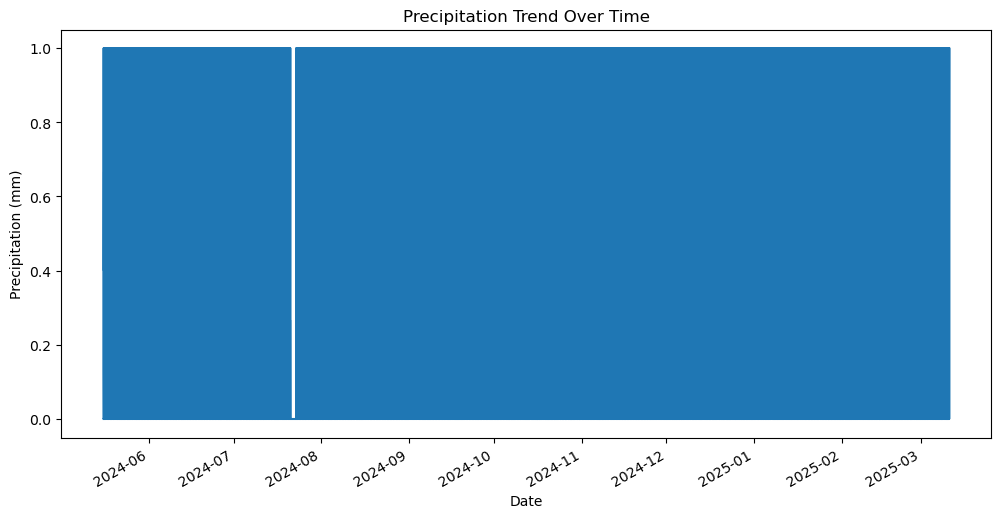

In [6]:
# Plot Precipitation Trend
if 'precip_mm' in df.columns:
    plt.figure(figsize=(12, 6))
    df['precip_mm'].plot(title="Precipitation Trend Over Time")
    plt.xlabel("Date")
    plt.ylabel("Precipitation (mm)")
    plt.show()
else:
    print("'precip_mm' column not found in the dataset.")


### Correlation Heatmap

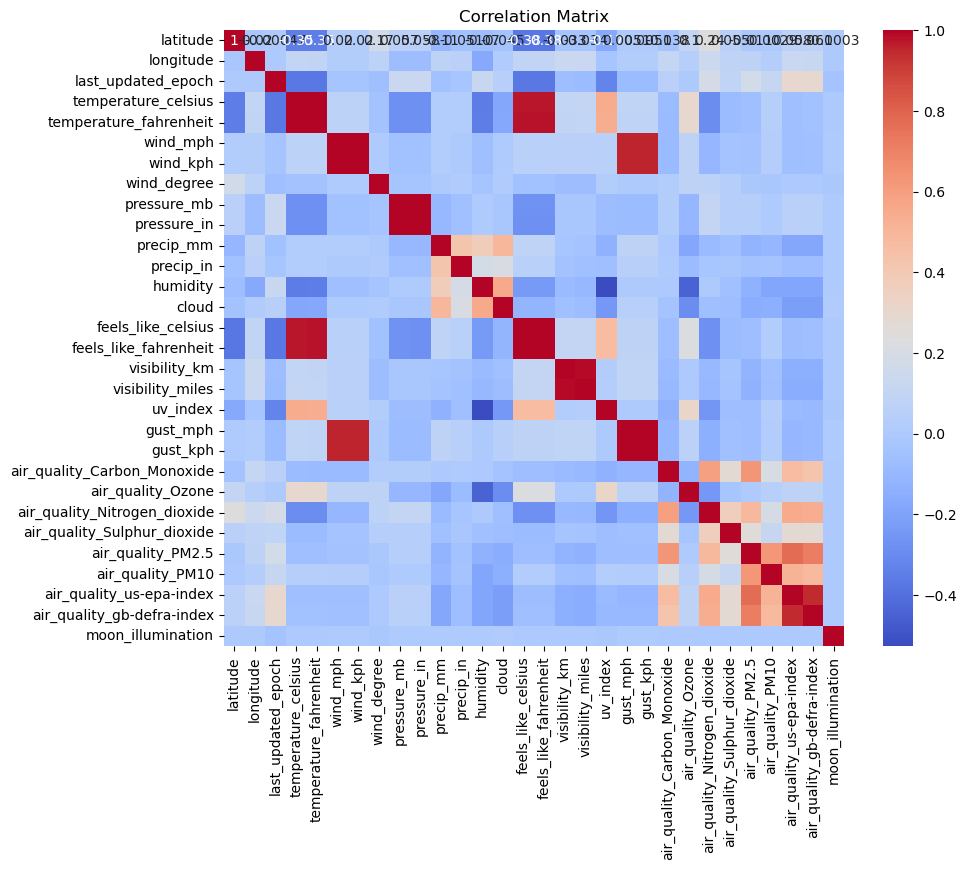

In [7]:
# Creating a heatmap to visualize correlations between numeric columns.
# This helps me identify which variables are strongly related.
numeric_cols = df.select_dtypes(include=[np.number])  # Select numeric columns
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_cols.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# Model Building Using ARIMA (Time Series Forecasting)

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-

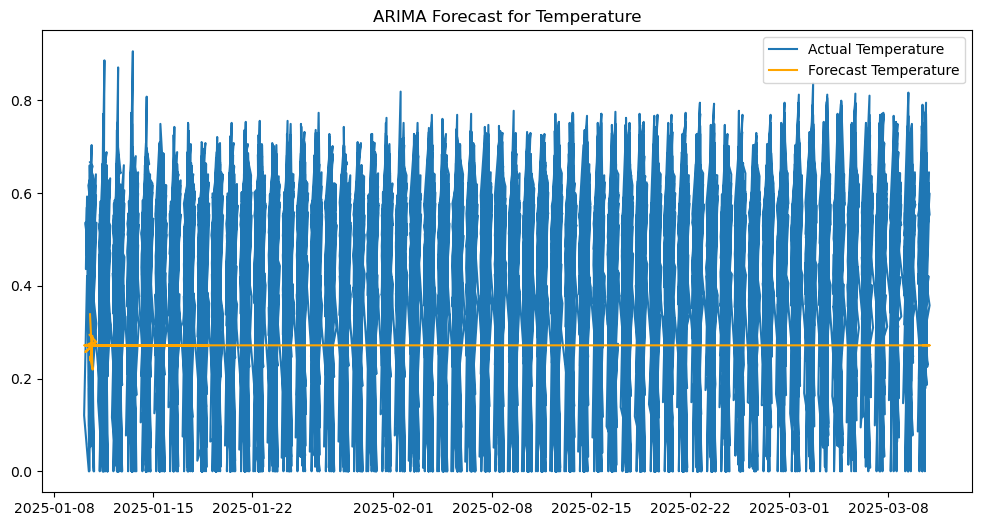

ARIMA Model Performance:
Mean Absolute Error (MAE): 0.22974007657606665
Root Mean Squared Error (RMSE): 0.25799153380206885


In [8]:
# Splitting the temperature data into training and testing sets.
# I am using 80% of the data for training and 20% for testing.
if 'temperature_celsius' in df.columns:
    temperature_series = df['temperature_celsius']

    # Splitting the data
    train_size = int(len(temperature_series) * 0.8)
    train, test = temperature_series[:train_size], temperature_series[train_size:]
else:
    print("'temperature_celsius' column not found for ARIMA forecasting.")

# Building an ARIMA model with (p,d,q) parameters.
model = ARIMA(train, order=(5, 1, 0))  
model_fit = model.fit()

# Forecasting future temperatures based on the test set.
Arima_forecast = model_fit.forecast(steps=len(test))

# Plotting the actual vs forecasted values.
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label="Actual Temperature")
plt.plot(test.index, Arima_forecast, label="Forecast Temperature", color='orange')
plt.legend()
plt.title("ARIMA Forecast for Temperature")
plt.show()

# Evaluating the model's accuracy using MAE and RMSE.
mae = mean_absolute_error(test, Arima_forecast)
rmse = np.sqrt(mean_squared_error(test, Arima_forecast))

# Displaying model performance
print("ARIMA Model Performance:")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


# Anomaly detection to identify and analyze outliers

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Number of anomalies detected: 2894


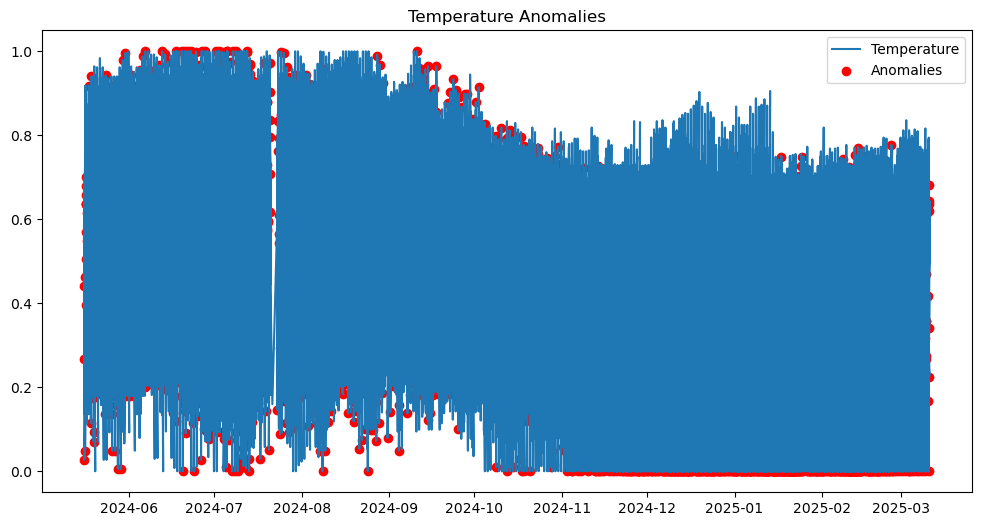

In [9]:
from sklearn.ensemble import IsolationForest

# Implement anomaly detection using Isolation Forest
numeric_cols = df.select_dtypes(include=[np.number]).columns
iso = IsolationForest(contamination=0.05, random_state=42)
df['anomaly'] = iso.fit_predict(df[numeric_cols])

# Analyze anomalies
anomalies = df[df['anomaly'] == -1]
print(f"Number of anomalies detected: {len(anomalies)}")

# Visualize anomalies in temperature
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['temperature_celsius'], label='Temperature')
plt.scatter(anomalies.index, anomalies['temperature_celsius'], color='red', label='Anomalies')
plt.title("Temperature Anomalies")
plt.legend()
plt.show()


# Forecasting with Multiple Models

## Model Building (Prophet)

00:28:13 - cmdstanpy - INFO - Chain [1] start processing
00:28:23 - cmdstanpy - INFO - Chain [1] done processing


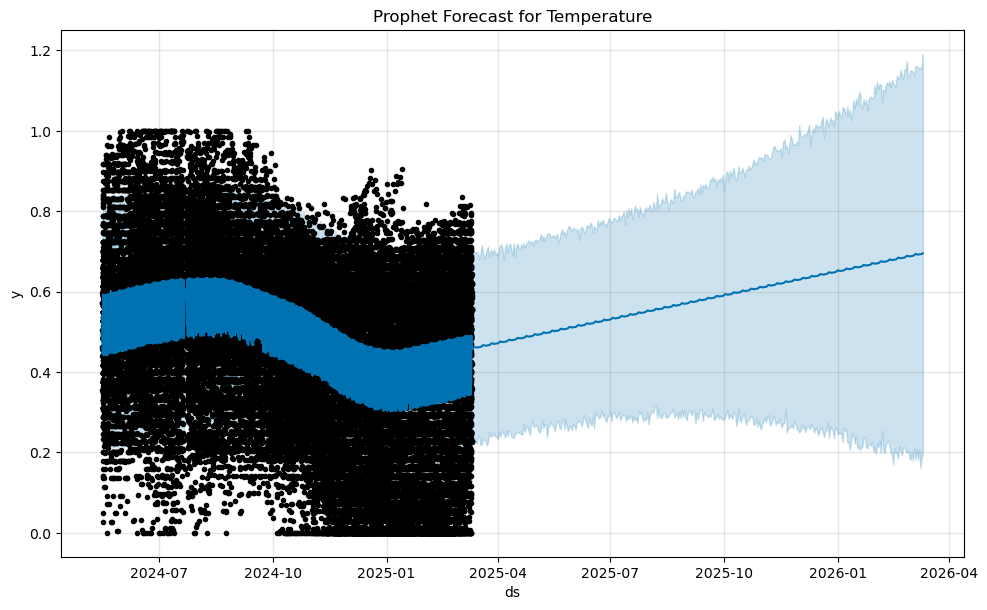

In [10]:
from prophet import Prophet

# Prepare data for Prophet
prophet_df = df.reset_index()[['last_updated', 'temperature_celsius']].rename(columns={'last_updated': 'ds', 'temperature_celsius': 'y'})

# Build and fit the Prophet model
prophet_model = Prophet()
prophet_model.fit(prophet_df)

# Create a future dataframe and forecast
future = prophet_model.make_future_dataframe(periods=365)  # Forecast for 1 year
forecast = prophet_model.predict(future)

# Plot the forecast
prophet_model.plot(forecast)
plt.title("Prophet Forecast for Temperature")
plt.show()


## Model Building (Gradient Boosting Regressor)

In [11]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Prepare data for Gradient Boosting
X = df.drop(columns=['temperature_celsius', 'anomaly'], errors='ignore')
y = df['temperature_celsius']

# Encode categorical features
X = pd.get_dummies(X, drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build and fit Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)

# Forecast
gbr_forecast = gbr.predict(X_test)

# Evaluate Gradient Boosting Model
gbr_mae = mean_absolute_error(y_test, gbr_forecast)
gbr_rmse = np.sqrt(mean_squared_error(y_test, gbr_forecast))
print(f"Gradient Boosting Performance:\nMAE: {gbr_mae}, RMSE: {gbr_rmse}")


Gradient Boosting Performance:
MAE: 0.001023394826792832, RMSE: 0.0014596570580759386


## Combining Models

In [12]:
print(f"Shape of ARIMA forecast: {Arima_forecast.shape}")
print(f"Shape of Prophet forecast: {forecast.shape}")
print(f"Shape of Gradient Boosting forecast: {gbr_forecast.shape}")
print(f"Shape of Test data: {test.values.shape}")


Shape of ARIMA forecast: (11576,)
Shape of Prophet forecast: (10057, 19)
Shape of Gradient Boosting forecast: (11576,)
Shape of Test data: (11576,)


In [13]:
min_length = min(len(forecast['yhat']), len(gbr_forecast), len(Arima_forecast), len(test))

# Align all arrays
prophet_forecast = forecast['yhat'][:min_length]
gradient_boosting_forecast = gbr_forecast[:min_length]
arima_forecast = Arima_forecast[:min_length]
test_values = test.values[:min_length]

# Convert GBR predictions to Pandas Series for smooth addition
gradient_boosting_forecast = pd.Series(gradient_boosting_forecast, index=test.index[:min_length])

# Combine the predictions (NO TEST DATA INCLUDED)
ensemble_forecast = (prophet_forecast.values + gradient_boosting_forecast.values + arima_forecast.values) / 3

# Evaluate Ensemble Model
ensemble_mae = mean_absolute_error(test_values, ensemble_forecast)
ensemble_rmse = np.sqrt(mean_squared_error(test_values, ensemble_forecast))

# Print results
print(f"Ensemble Model Performance:\nMAE: {ensemble_mae:}\nRMSE: {ensemble_rmse:}")


Ensemble Model Performance:
MAE: 0.2042280064158712
RMSE: 0.24184843866339434


In [14]:
# Combine predictions into a new DataFrame
ensemble_df = pd.DataFrame({
    'Prophet': prophet_forecast.values,
    'GBR': gradient_boosting_forecast,
    'ARIMA': arima_forecast.values
})

# Build a Stacking Model (Meta Model)
meta_model = GradientBoostingRegressor(random_state=42)
meta_model.fit(ensemble_df, test_values)

# Predict using the Stacking Model
ensemble_forecast = meta_model.predict(ensemble_df)

# Evaluate Ensemble Model
ensemble_mae = mean_absolute_error(test_values, ensemble_forecast)
ensemble_rmse = np.sqrt(mean_squared_error(test_values, ensemble_forecast))

# Print results
print(f"Optimized Ensemble Model Performance:\nMAE: {ensemble_mae}\nRMSE: {ensemble_rmse}")

Optimized Ensemble Model Performance:
MAE: 0.19795600632089674
RMSE: 0.22525184835938256


# Unique Analysis

## Climate Analysis

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


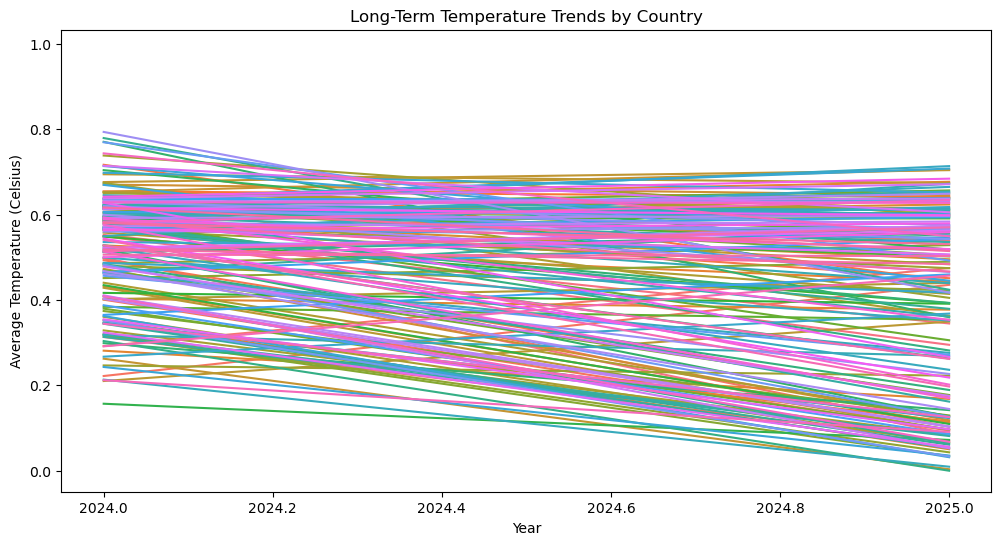

In [15]:
# Long-term trends grouped by region
# Extract the year from the datetime index
df['year'] = df.index.year

# Group by country and year, then calculate the mean temperature
regional_trends = df.groupby(['country', 'year'])['temperature_celsius'].mean().reset_index()

# Visualize long-term temperature trends by country
plt.figure(figsize=(12, 6))
sns.lineplot(data=regional_trends, x='year', y='temperature_celsius', hue='country', legend=None)
plt.title("Long-Term Temperature Trends by Country")
plt.xlabel("Year")
plt.ylabel("Average Temperature (Celsius)")
plt.show()


## Environmental Impact

Correlation between Air Quality Metrics and Temperature:
air_quality_Carbon_Monoxide    -0.080457
air_quality_Ozone               0.300914
air_quality_Nitrogen_dioxide   -0.292066
air_quality_Sulphur_dioxide    -0.080332
air_quality_PM2.5              -0.065338
air_quality_PM10                0.037296
air_quality_us-epa-index       -0.062352
air_quality_gb-defra-index     -0.051309
temperature_celsius             1.000000
Name: temperature_celsius, dtype: float64


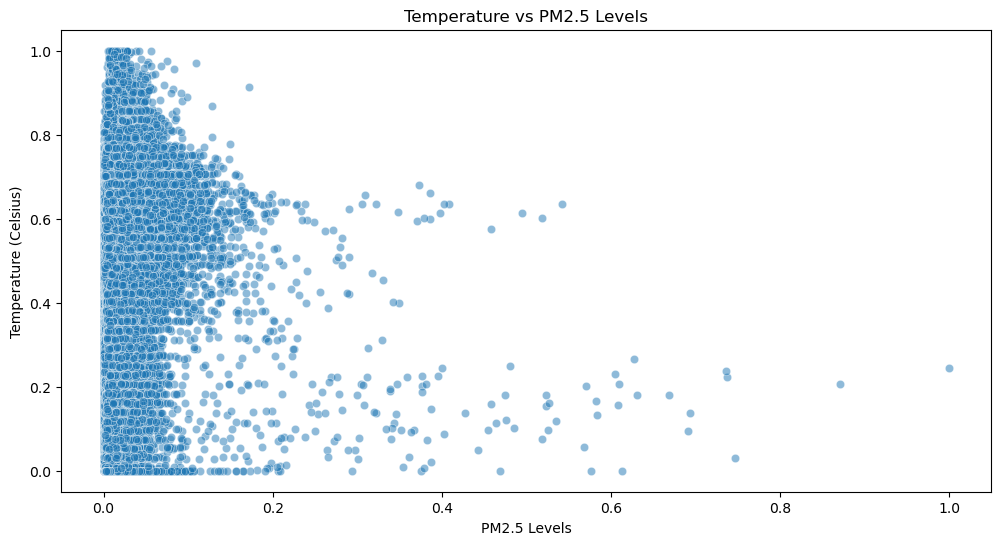

In [16]:
# Correlation between air quality and temperature
air_quality_cols = [col for col in df.columns if 'air_quality' in col]
correlations = df[air_quality_cols + ['temperature_celsius']].corr()['temperature_celsius']
print("Correlation between Air Quality Metrics and Temperature:")
print(correlations)

# Visualize air quality vs. temperature
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='air_quality_PM2.5', y='temperature_celsius', alpha=0.5)
plt.title("Temperature vs PM2.5 Levels")
plt.xlabel("PM2.5 Levels")
plt.ylabel("Temperature (Celsius)")
plt.show()


## Feature Importance

In [ ]:
# Feature importance using Random Forest
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# Feature importance visualization
importance = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_}).sort_values(by='Importance', ascending=False)

# Plotting the top 20 most important features
plt.figure(figsize=(14, 6))
sns.barplot(data=importance.head(20), x='Importance', y='Feature', palette='viridis')
plt.title("Top 20 Feature Importance in Predicting Temperature")
plt.show()

## Spatial Analysis

<ipython-input-26-1bba1573555e>:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


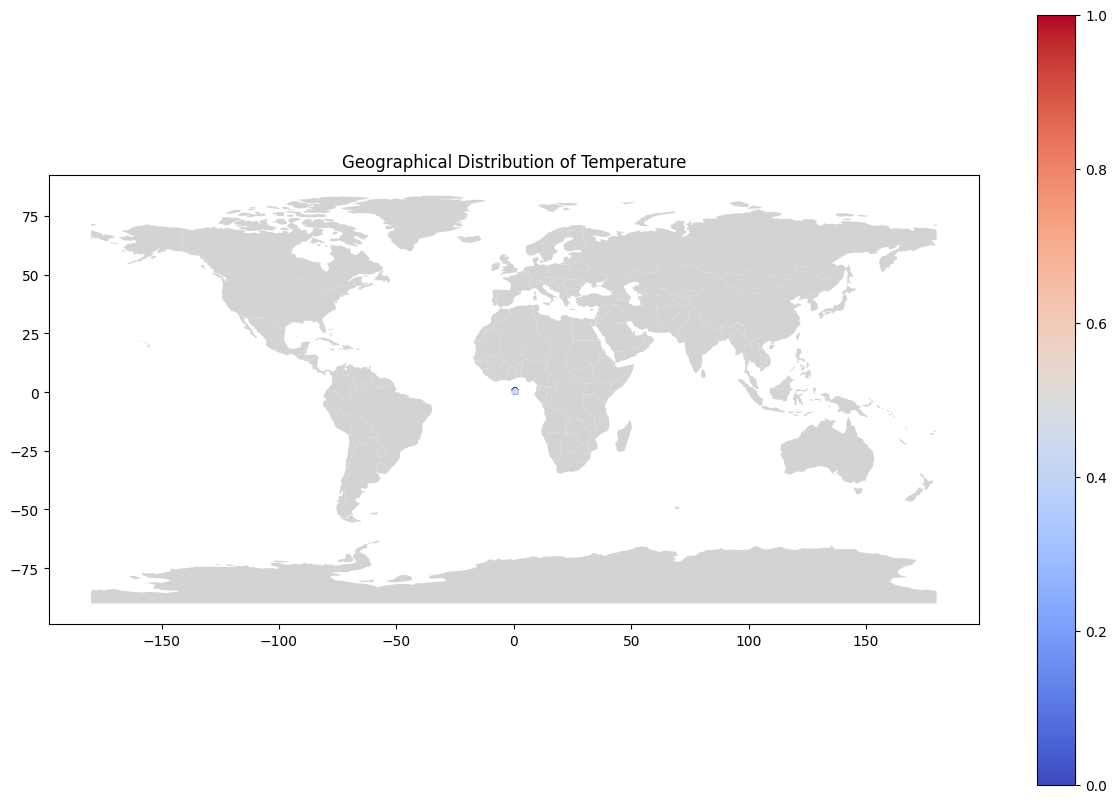

In [ ]:
import geopandas as gpd

# Visualize average temperature geographically
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitude'], df['latitude']))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Plot temperature distribution on the map
fig, ax = plt.subplots(figsize=(15, 10))
world.plot(ax=ax, color='lightgrey')
gdf.plot(column='temperature_celsius', ax=ax, legend=True, cmap='coolwarm', markersize=5)
plt.title("Geographical Distribution of Temperature")
plt.show()


## Geographical Patterns

Average Temperature by Continent:
continent
Asia      0.450622
Europe    0.516414
Name: temperature_celsius, dtype: float64


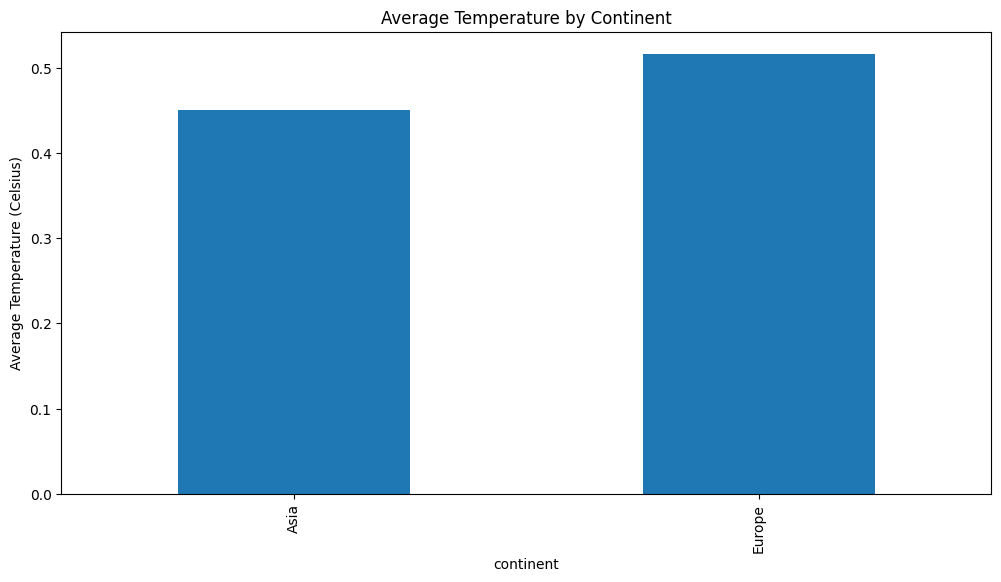

In [ ]:
# Compare average temperature by continent
df['continent'] = df['country'].map({
    # Add country-to-continent mapping
    'Afghanistan': 'Asia',
    'Albania': 'Europe',
    # Add other mappings as necessary
})

continent_temp = df.groupby('continent')['temperature_celsius'].mean()
print("Average Temperature by Continent:")
print(continent_temp)

continent_temp.plot(kind='bar', title="Average Temperature by Continent", figsize=(12, 6))
plt.ylabel("Average Temperature (Celsius)")
plt.show()
